In [27]:
import pickle

import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import arviz as az

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample


from models import deconvolution

from scipy.stats import gaussian_kde


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

torch.set_default_device(device)

## Inverse problem 

In [28]:
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.01**2
mu_u = -1
sigma_2_u = 0.01**2

n = 2*N
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

params = [0, 0.8, 0.1, 1.0, 0]

def problem_system(grid: np.array, params)-> np.array:

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= 0.1:
            output[idx] = params[0]
        elif point <= 0.2:
            output[idx] = params[1]
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.75:
            #output[idx] = params[3]
            output[idx] = params[3] #+ 0.3*np.sin(2*np.pi*point*2)
        else:
            output[idx] = point*params[4]
    
    return output



## Convolution matrix

In [29]:
model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

#A[0,0] = 0
#A[-1, -1] = 0

## Data Generation

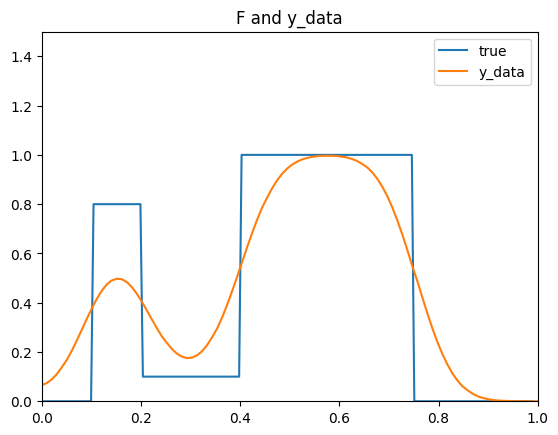

In [30]:
# Generate grid points
x = np.linspace(0, domain[1] - h, n)

# Construct the function f
f = problem_system(x, params)
#f = np.sin(10*x-0.2)
f = A@f
ind = f > 0
f *= ind

# Create y_data with noise
y_data = f + np.random.normal(0, sigma_noise, f.shape)

f = problem_system(x, params)

# Plot f and w
plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='y_data')
plt.axis([domain[0], domain[1], 0, 1.5])
plt.title('F and y_data')
plt.legend()
plt.show()

Old targets

## Pyro BNN

In [31]:
class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Cauchy(0.,
                                                torch.tensor(1.)).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Cauchy(0.,
                                               torch.tensor(1.)).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(1.0)).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(1.,
                                               torch.tensor(1.0)).expand([h2]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](h1, h2)
        self.fc3.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(1.0)).expand([h2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(1.0)).expand([h2]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        
        x = x#.reshape(-1, 1)

        mu = self.relu(self.fc1(x))
        mu = self.relu(self.fc2(mu))
        mu = self.relu(self.fc3(mu))
        #mu = x
        sigma = pyro.sample("sigma", dist.Uniform(0.,
                                                torch.tensor(0.05)))
    
        with pyro.plate("data", 200):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu
    

In [32]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(t).float()
y_train = torch.from_numpy(y_data).float()


## Load BNN model for signals, Prior

In [33]:
bnn_model = BNN(h1=N, h2=n)

In [34]:
predictive = torch.load('../bnn_prior_cpu.pt')

#### Generate prior for the y

In [35]:
y_train.device

device(type='cpu')

In [36]:
prior_bnn = predictive(y_train)

In [37]:
prior_bnn = prior_bnn['obs']
prior_bnn.shape

torch.Size([5000, 200])

In [38]:
prior = gaussian_kde(prior_bnn.cpu().numpy().T)

prior_test = prior(f)


#### Plotting the prior

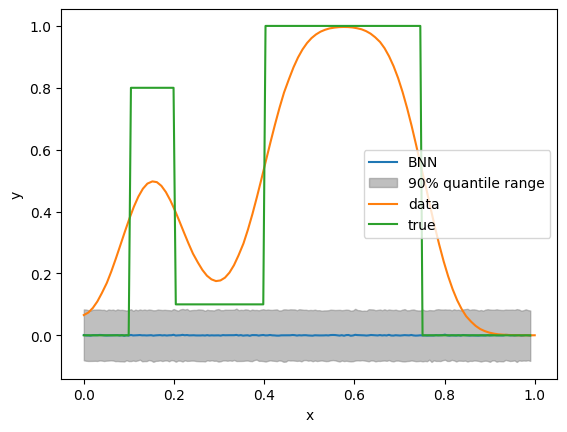

In [39]:
# Calculate mean and quantiles
prior_mean = torch.mean(prior_bnn, axis=0).cpu()
lower_quantile = torch.quantile(prior_bnn, 0.05, axis=0).cpu()
upper_quantile = torch.quantile(prior_bnn, 0.95, axis=0).cpu()

# Plot the mean prediction
plt.plot(x, prior_mean, label='BNN')

# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color='gray', alpha=0.5, label='90% quantile range')

# Plot the true data and the true function
plt.plot(t, y_data, label='data')
plt.plot(x, f, label='true')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()


## MCMC

In [40]:
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm

In [41]:
def model(A, x):
    return np.matmul(A, x)


def neg_log_likelihood_without_sigma(x, y_data, A):
    'Derived using pen and paper'
    n = len(x)
    residual =  y_data - model(A, x)
    return  1/2*sum(residual**2)


def neg_log_likelihood_sigma(sigma, y_data, A, x):
    n = len(x)
    residual =  y_data - model(A, x)
    return n/2*np.log(2*np.pi) + n*np.log(sigma) +  1/2*sum(residual**2)/sigma**2


res = minimize(neg_log_likelihood_without_sigma,
                prior_mean,
                method='nelder-mead',
                args=(y_data, A),
                options={'xatol': 1e-8,
                'disp': True})
theta_neg_log = res.x
print(f'Theta: {theta_neg_log}\n')


res = minimize(neg_log_likelihood_sigma,
                1,
                method='nelder-mead',
                args=(y_data, A, theta_neg_log),
                options={'xatol': 1e-8,
                'disp': True})
sigma = res.x
print(f'Sigma: {sigma}')

Theta: [ 1.99771796e-01 -1.24214720e-01 -1.04720850e-01 -7.57444250e-02
 -1.10748917e-01  2.85153866e-02  4.50618442e-02  1.03936394e-01
  2.11625283e-01  1.20002527e-02  1.27510196e-01  4.77566332e-02
 -3.83362985e-02  6.64914817e-02 -1.08505621e-01  9.04537134e-02
  3.11969806e-01  2.12239439e-01  3.80135823e-01  2.88101386e-03
  2.01391980e-01  4.07705588e-02  2.81945653e-01 -2.26431504e-02
  9.27479490e-04  1.47314924e-01 -9.65030967e-03 -5.09004386e-04
 -1.09229051e-03  1.42883088e-04  1.56464580e-01  3.88665045e-01
  8.03836201e-03  1.47257100e-02  7.77849054e-02  1.82949459e-01
  6.59073756e-03  1.94274121e-01  2.97775512e-03  6.09628259e-02
  7.69409926e-01  8.95620055e-02 -4.30912089e-02  3.35372599e-02
  3.45997354e-01  3.14109281e-02  1.05881548e-01  1.25204450e-01
  3.72244188e-03  1.50914314e-01  2.02722994e-01  9.23434560e-02
  2.58970610e-01 -2.88165706e-03 -6.18139533e-02  5.80878844e-02
  5.56974449e-02 -3.62773783e-04  2.33474642e-01  4.13437348e-02
 -5.80535523e-03  

/tmp/ipykernel_2265100/3627979120.py:15: RuntimeWarning: invalid value encountered in log
  return n/2*np.log(2*np.pi) + n*np.log(sigma) +  1/2*sum(residual**2)/sigma**2


In [42]:
def negative_log_posterior(theta, A, y, mu_prior=0, sigma_prior=0.05, sigma_likelihood=1):
    """
    Calculate the negative log posterior for the model A*x.

    Parameters:
    theta (numpy array): Parameters for the model
    A (numpy array): Matrix for the model A*x
    x (numpy array): Observed data
    mu_prior (float): Mean of the Gaussian prior
    sigma_prior (float): Standard deviation of the Gaussian prior
    sigma_likelihood (float): Standard deviation of the Gaussian likelihood

    Returns:
    float: Negative log posterior
    """
    # Calculate the likelihood
    Ax = A @ theta
    log_likelihood = -0.5 * np.sum((y - Ax)**2) / sigma_likelihood**2 - 0.5 * len(x) * np.log(2 * np.pi * sigma_likelihood**2)
    
    # Calculate the prior
    log_prior = prior.logpdf(theta)
    
    # Calculate the negative log posterior
    neg_log_posterior = -(log_likelihood + log_prior)
    
    return neg_log_posterior

In [43]:
from pymcmcstat.MCMC import MCMC
mcstat = MCMC()

# Adding data and initializing parameters for the MCMC
mcstat.data.add_data_set(A, y_data)
for ii in range(n):
    mcstat.parameters.add_model_parameter(name=f'x_{ii}', theta0=prior_mean[ii], minimum=-0.1, maximum=3.0)
#mcstat.parameters.add_model_parameter(name=f'sigma', theta0=0.05, minimum=0., maximum=0.1)


mcstat.simulation_options.define_simulation_options(nsimu=3000,
                                                    method='dram',
                                                    burnin_scale=1000,
                                                    verbosity=1,
                                                    waitbar=1)

def ssfun(x, data):
    'Derived using pen and paper'
    A = data.xdata[0].reshape(100,200)
    y_data = data.ydata[0]

    n = len(x)
    x = x.reshape(-1,1)
    return  np.exp(-negative_log_posterior(x, A, y_data))

def log_prior(params, a, b):
    # Evaluate the KDE log density for the parameter vector
    log_prob = prior(params.reshape(-1, 1))
    
    return log_prob


mcstat.model_settings.define_model_settings(sos_function=ssfun,
                                            prior_function=log_prior)

# Simulation and extracting results
mcstat.run_simulation()
results = mcstat.simulation_results.results


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
       x_0:  8.23e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
       x_1: -3.06e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
       x_2: -3.85e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
       x_3: -1.01e-03 [    -0.10,      3.00] N( 0.00e+00,      inf)
       x_4:  3.69e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
       x_5:  2.12e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
       x_6:  3.82e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
       x_7:  1.16e-03 [    -0.10,      3.00] N( 0.00e+00,      inf)
       x_8:  8.73e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
       x_9: -9.90e-05 [    -0.10,      3.00] N( 0.00e+00,      inf)
      x_10: -5.44e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
      x_11: -3.73e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
      x_12: -2.79e-04 [    -0.10,      3.00] N( 0.00e+00,      inf)
      x_13:  2.11e-

In [44]:
def create_pymc_prior(data):
    kdes = []

    # Fit a KDE to each variable (column)
    for i in range(data.shape[1]):
        kde = gaussian_kde(data[:, i])
        kdes.append(kde)
    return kdes

def pymc_prior(data, kdes):
    densities = np.empty(data.shape)
    for ii in range(len(kdes)):
        densities[ii] = kdes[ii](data[ii])

    return densities

kdes = create_pymc_prior(prior_bnn)

pymc_prior(f, kdes).shape

(200,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.
/home/akseli/dippa/.venv/lib/python3.10/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (201) in plot_posterior, generating only 40 plots
  warnings.warn(


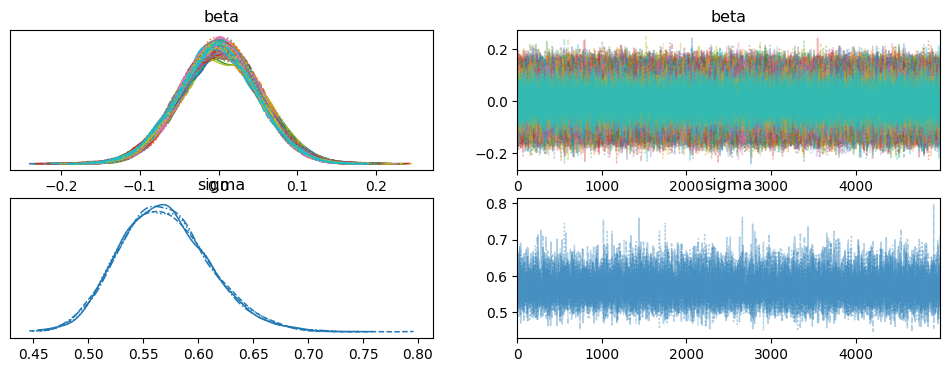

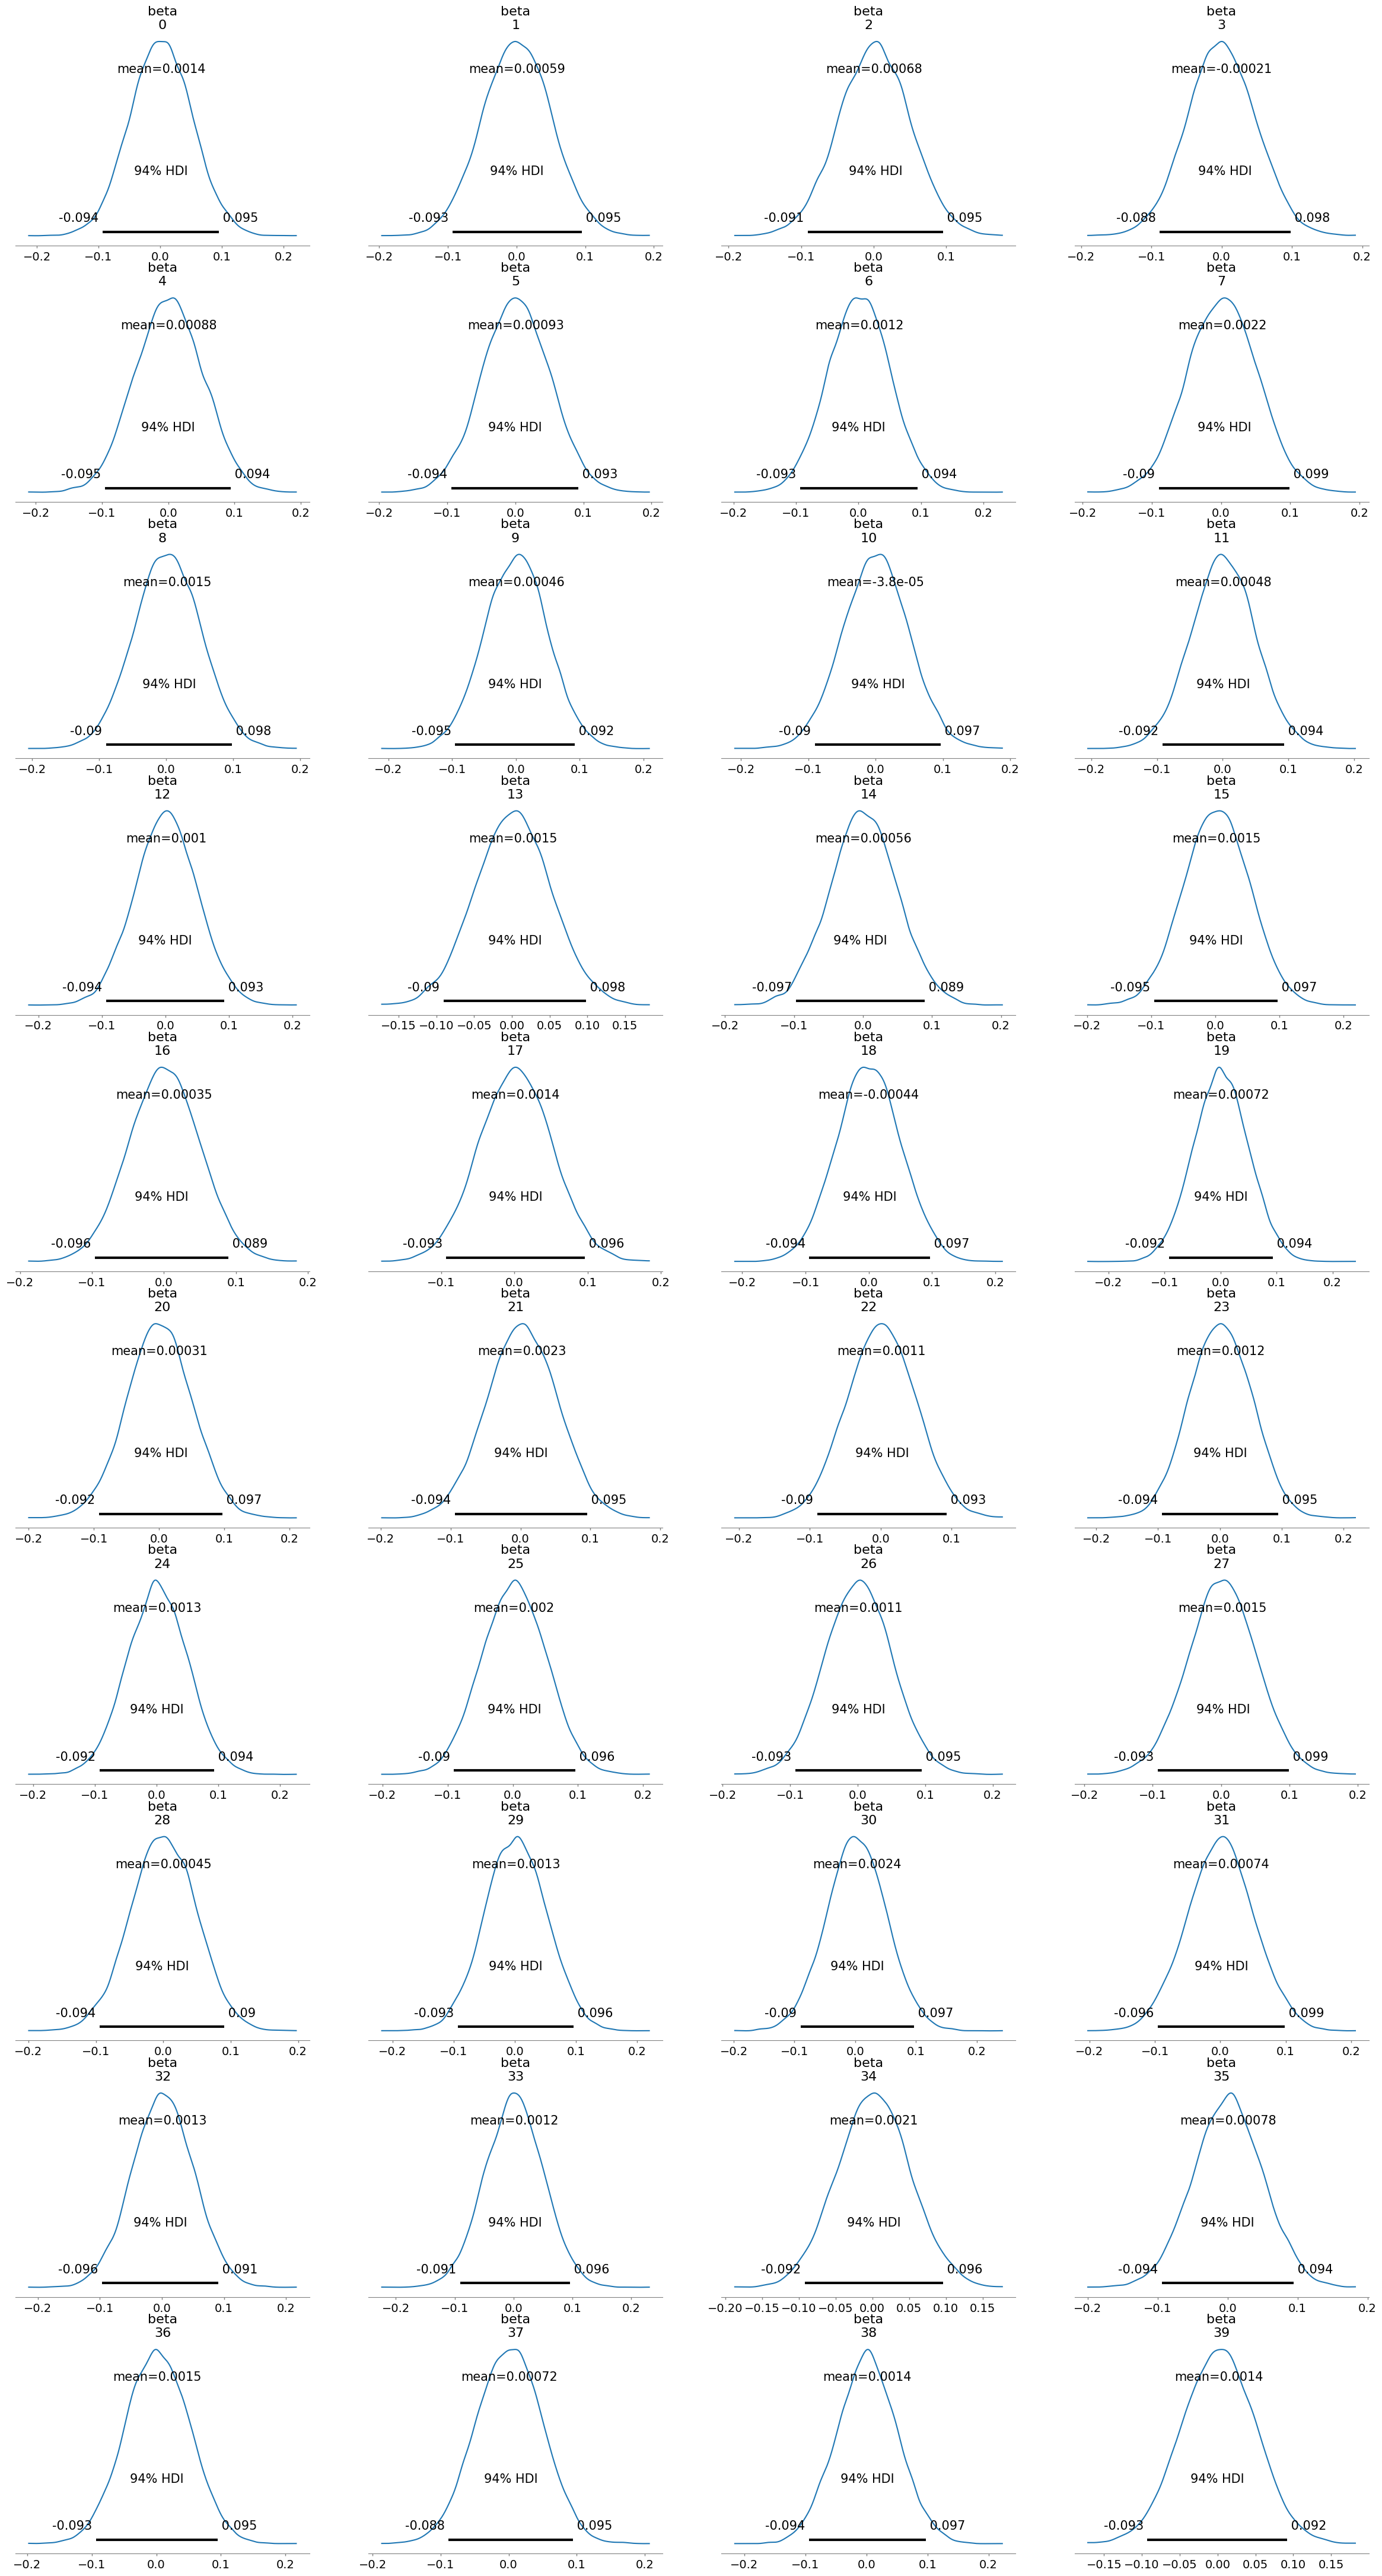

In [45]:
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample


# Define the PyMC model
with pm.Model() as model:
    
    # Priors for the regression coefficients
    beta = pm.Normal('beta', mu=prior_mean.numpy(), sigma=np.std(prior_bnn.numpy(), axis=0), shape=(n,))
    
    # Prior for the noise standard deviation
    sigma = pm.HalfNormal('sigma', sigma=0.5)

    # Likelihood
    mu = pm.math.dot(A, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_data)
    
    # Use the NUTS sampler
    trace = pm.sample(5000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Plot the results
az.plot_trace(trace)
az.plot_posterior(trace)
plt.show()


In [46]:
# Print summary of the trace
print(az.summary(trace, var_names=['beta', 'sigma']))

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]    0.001  0.050  -0.094    0.095        0.0      0.0   29950.0   
beta[1]    0.001  0.050  -0.093    0.095        0.0      0.0   29052.0   
beta[2]    0.001  0.049  -0.091    0.095        0.0      0.0   37274.0   
beta[3]   -0.000  0.050  -0.088    0.098        0.0      0.0   32448.0   
beta[4]    0.001  0.051  -0.095    0.094        0.0      0.0   30193.0   
...          ...    ...     ...      ...        ...      ...       ...   
beta[196] -0.000  0.049  -0.094    0.089        0.0      0.0   31685.0   
beta[197]  0.000  0.050  -0.093    0.094        0.0      0.0   35718.0   
beta[198] -0.000  0.049  -0.094    0.091        0.0      0.0   31281.0   
beta[199] -0.002  0.050  -0.095    0.092        0.0      0.0   34753.0   
sigma      0.570  0.041   0.494    0.646        0.0      0.0   34548.0   

           ess_tail  r_hat  
beta[0]     15248.0    1.0  
beta[1]     16316.0    1.0  
beta[2]     14666.0    1

In [47]:
# Extract posterior means
posterior_means = trace.posterior['beta'].mean(dim=['chain', 'draw']).values

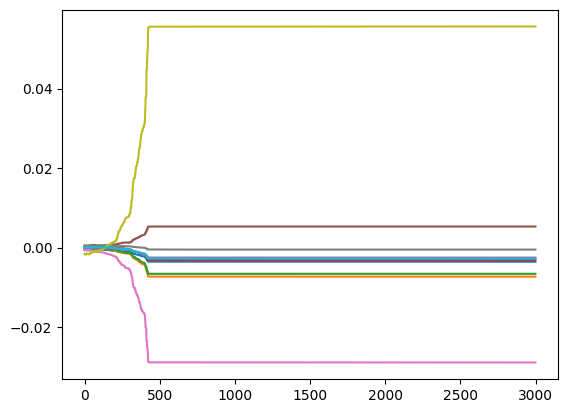

In [48]:
posterior_samples = results['chain']
plt.plot(posterior_samples[:,10:20])
# Compute the mean of each omega_i
mean_omega = np.mean(posterior_samples, axis=0)


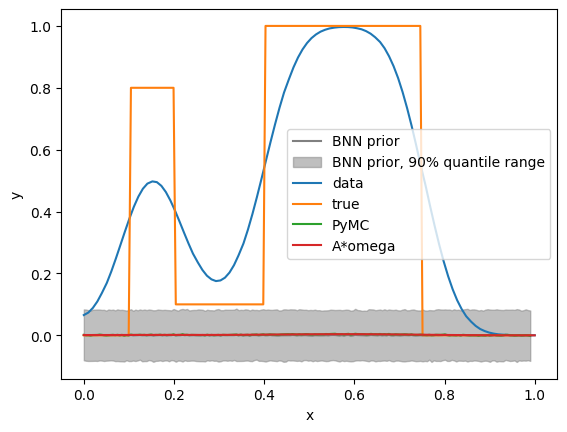

In [49]:
lower_quantile_omega = np.quantile(posterior_samples, q=0.40, axis=0)
upper_quantile_omega = np.quantile(posterior_samples, q=0.60, axis=0)

plt.plot(x, prior_mean, color='gray', label='BNN prior')
# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color='gray', alpha=0.5, label='BNN prior, 90% quantile range')

# Plot the true data and the true function
plt.plot(t, y_data, label='data')
plt.plot(x, f, label='true')

#plt.plot(x, np.mean(posterior_samples, axis=0), label='pymcmcstat')
plt.plot(x, posterior_means, label='PyMC')
#plt.fill_between(x, lower_quantile_omega, upper_quantile_omega, color='g', alpha=0.5, label='Solution, 90% quantile range')

plt.plot(t, A@posterior_means, label='A*omega')
#plt.plot(t, A@f)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()